In [120]:
# Type annotations :
from typing import Tuple, List, Optional, NoReturn, Callable, Any

# Standard and OS :
import copy
import json
import glob
import os
import importlib # Required to reload a module
                 # because the Jupyter Kernel
                 # won't  really reimport by itself.
import multiprocessing as mp

# Image processing :
import cv2 as cv
import skimage
from skimage.feature import canny, peak_local_max
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte, img_as_float
from skimage import exposure
from skimage.morphology import disk, skeletonize, thin, medial_axis, watershed, max_tree
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
import skimage.measure as measure
#from skimage.morphology import black_tophat, skeletonize, convex_hull_image
#from skimage.morphology import disk

from skimage.filters import rank
from skimage.measure import label, regionprops

# Numeric :
import numpy as np
import pandas as pd
from scipy import ndimage as ndi

# Visualisation :
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Machine-Learning :
from sklearn.cluster import KMeans

# Functional programing tools : 
from functools import partial, reduce
from itertools import chain


In [228]:
import mfilt_funcs as mfs
importlib.reload(mfs)
import mfilt_funcs as mfs

import utils
importlib.reload(utils)
import utils

import forutils
importlib.reload(forutils)
from forutils import find_branch_points

In [263]:
lmap = lambda x, y: list(map(x, y))
lfilter = lambda x, y: list(filter(x, y))
imread = lambda x: cv.imread(x, 0)
pad_obj = lambda x: cv.copyMakeBorder(np.float64(x.image), 10, 10, 10, 10, cv.BORDER_CONSTANT)
pad  = lambda x: cv.copyMakeBorder(np.float64(x), 10, 10, 10, 10, cv.BORDER_CONSTANT)
pad1 = lambda x: cv.copyMakeBorder(np.float64(x), 1, 1, 1, 1, cv.BORDER_CONSTANT)

In [4]:
plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (12, 8)

In [5]:

def auto_segment(
    img: np.ndarray, 
    groups: int = 2,
    nonzero: bool = False,
    verbose: bool = False, 
    save_file: Optional[str] = None,
    figsize: Optional[Tuple[int]] = (12, 8)
) -> np.ndarray:
    """
        Segment (by thresholding)
    """
    
    assert type(groups) is int, f"type(groups) == '{type(groups)}', it should be int."
    
    #Create the destination image from the image passed to the function, casting it when needed.
    _floats = [np.float, np.float16, np.float32, np.float64, np.float128]
    if img.dtype in _floats:
        dst: np.ndarray = copy.deepcopy(img)
    else:
        dst: np.ndarray = copy.deepcopy(np.float64(img) / 255)
    
    # We perform K-Means clustering analysis :
    _intensities = img.flatten()
    _show_intensities = _intensities.copy()
    if nonzero:
        _intensities = _intensities[_intensities.nonzero()]
    _kmeans = KMeans(n_clusters=groups, random_state=0, verbose=verbose).fit(_intensities.reshape(-1, 1))
    _centers = pd.core.frame.DataFrame({
        "means": chain.from_iterable(_kmeans.cluster_centers_)
    })
    _centers = _centers.sort_values(by=['means'])
    
    # We obtain our threshold values as pairwise means between cluster centers.
    _centers['k'] = _centers.rolling(2).mean()
    
    # Create the values that will fill the image, according to the thresholds.
    _fill_vals = np.linspace(0, 1, groups, dtype=np.float64)
    
    # Fill the image with trheshold values.
    ks = [0] + _centers['k'].dropna().tolist()
    for j in range(len(ks) - 1):
        _mask = np.nonzero( (img > ks[j]) & (img < ks[j+1]) )
        dst[ _mask ] = _fill_vals[j]
    _mask = np.nonzero( img > ks[-1] )
    dst[ _mask ] = _fill_vals[-1]
    
    
    if verbose:
        fig = plt.figure(figsize = figsize)
        lmap(lambda x: plt.axvline(x, color='r'), _centers.k.dropna())
        lmap(lambda x: plt.axvline(x, color='g'), _centers.means)
        _ = sns.distplot(_show_intensities, kde=False)
        
        fig2 = plt.figure(figsize = figsize)
        fig2.add_subplot(1, 2, 1)
        plt.imshow(img, cmap = 'gray')
        plt.title('Original')
        fig2.add_subplot(1, 2, 2)
        plt.imshow(dst, cmap = 'gray')
        plt.title(f"Threshold ({groups} groups)")
        
        
        
    return dst
##

def ref_region(
    img: np.ndarray,
    selem: Any = disk(5),
    sigma: int = 3,
    opening_se: np.ndarray = np.ones((10, 10)),
    closing_se: np.ndarray = np.ones((5, 5)),
    verbose: bool = False
):
    """
    """
    
    # Perform histogram equalisation :
    _img_eq = rank.equalize(img, selem=selem)
    
    # Perform edge detection :
    _edges = canny(_img_eq, sigma=3)
    _filled = ndi.binary_fill_holes(_edges)
    
    # Morphological processing :
    _eroded = utils.closing(
        utils.opening(np.float64(_filled), opening_se), closing_se
    )
    
    if verbose:
        utils.side_by_side(img, _img_eq, title1="Original", title2="Histogram Equalised")
        #plt.title('Lol')
        utils.side_by_side(_img_eq, _filled, title1="Histogram Equalised", title2="Canny Edge Detection + Filled image")
        #plt.title('Lal')
        utils.side_by_side(_filled, _eroded, title1="Canny Edge Detection + Filled image", title2="Opening, closing")
        #plt.title('Lel')
        
    return _eroded

In [6]:
ls images/

Triangulos.PNG   altoflujo.png    bajo2flujo.png   triangulos2.jpg
alto2flujo.png   bajo1flujo.png   bajo3flujo.png


In [7]:
cwd  = os.path.abspath('.')
path = os.path.join(cwd, 'images')
pattern = os.path.join(path, '*flujo.png')
files = glob.glob(pattern)
files

['/Users/gml/Documents/IX/imagenes/ProyectoAsignadoImagenes/images/altoflujo.png',
 '/Users/gml/Documents/IX/imagenes/ProyectoAsignadoImagenes/images/bajo1flujo.png',
 '/Users/gml/Documents/IX/imagenes/ProyectoAsignadoImagenes/images/bajo2flujo.png',
 '/Users/gml/Documents/IX/imagenes/ProyectoAsignadoImagenes/images/bajo3flujo.png',
 '/Users/gml/Documents/IX/imagenes/ProyectoAsignadoImagenes/images/alto2flujo.png']

Todas nuestras imágenes de interés contienen la cadena de caracteres 'flujo.png'.

In [8]:
llaves = lmap(lambda x: os.path.split(x)[-1], files)

In [9]:
mangueras = {
    f"{nombre}": imread(file) for file, nombre in zip(files, llaves) 
}

In [10]:
intensities = pd.core.frame.DataFrame({
    key: mangueras[key].flatten() for key in mangueras.keys()
})

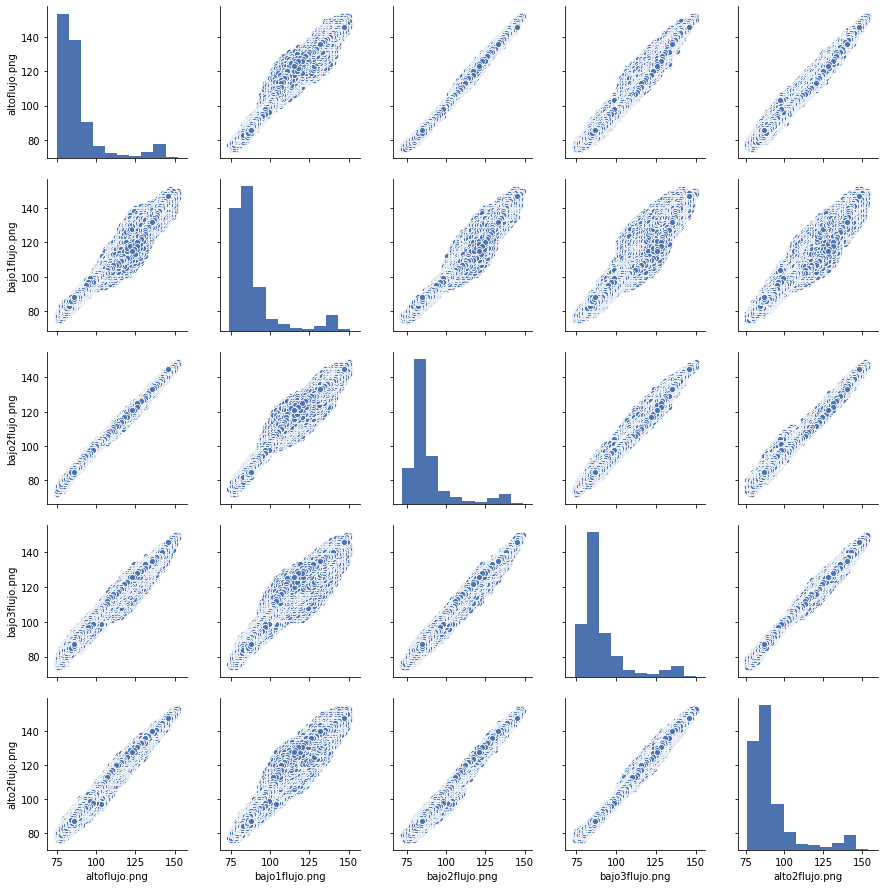

In [9]:
# SUPER SLOW ! 
# Do not run !
sns.pairplot(intensities)

Podemos observar una gran correlación entre las intensidades de todas las imágenes.

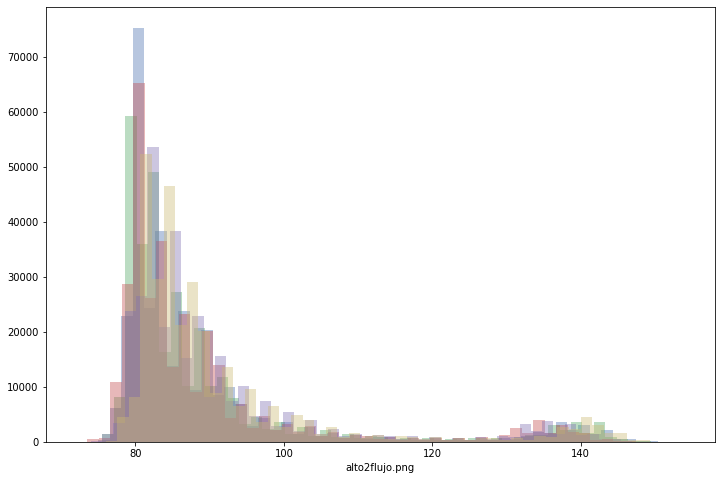

In [11]:
for i in intensities:
    sns.distplot(intensities[i],  kde=False)

Nótese lo similares que son las distribuciones de las intensidades, independientemente de la intensidad del flujo.

In [116]:
mangueras_segmentadas = {
    key: auto_segment(mangueras[key], verbose=False, groups=2) for key in mangueras.keys()
}

Aquí segmentamos automáticamente la región de la manguera, gracias al gran contraste que existe entre éste nuestro ente de interés y el fondo (muy claro el primero, oscuro el segundo).

Usamos la función que diseñamos : ```auto_segment()```

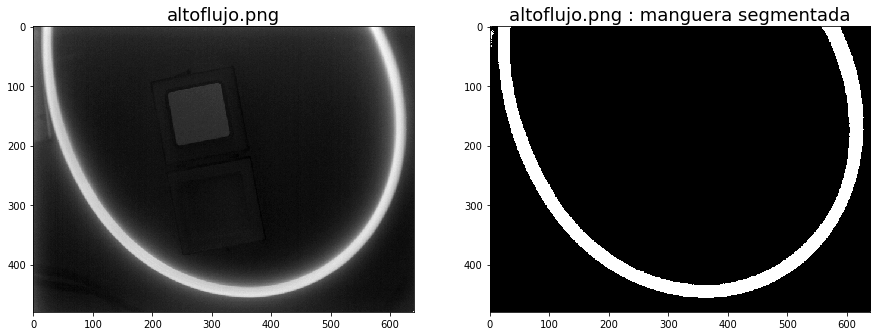

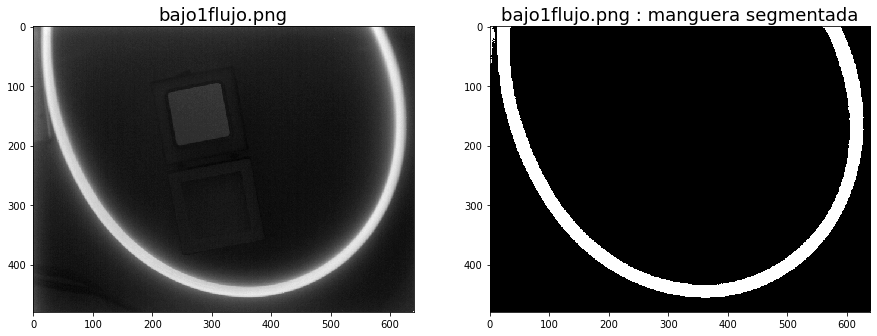

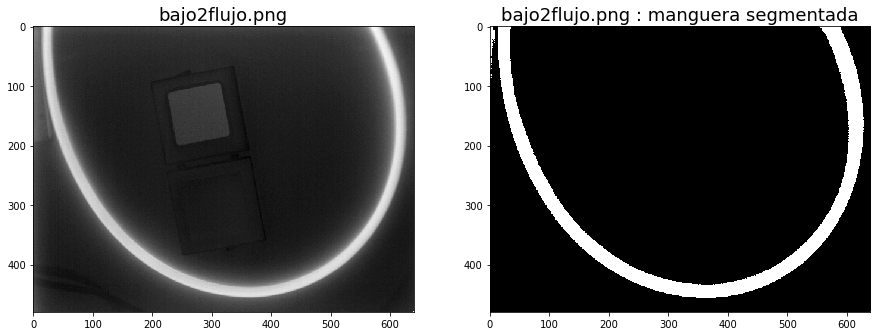

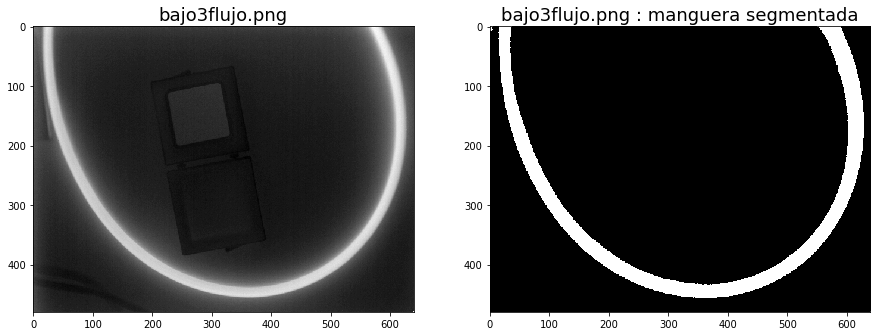

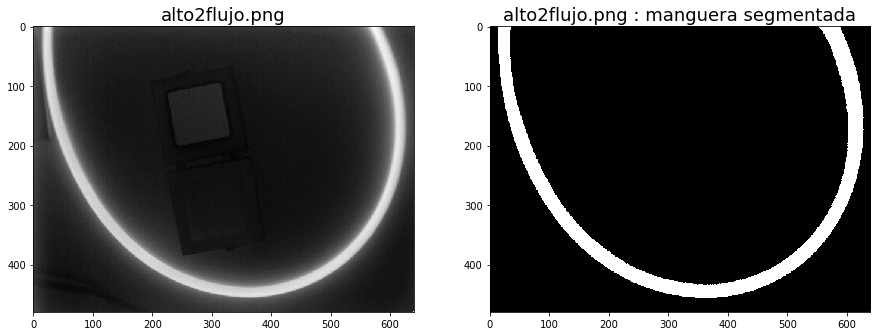

In [117]:
for nombre in mangueras.keys():
    utils.side_by_side(
        mangueras[nombre], mangueras_segmentadas[nombre], 
        title1=nombre, title2=f"{nombre} : manguera segmentada"
    )

Aquí podemos observar las imágenes con su respectiva máscara de segmentación.

In [17]:
region_ref1 = {
    key: auto_segment(mangueras[key], groups=3) for key in mangueras.keys()
}

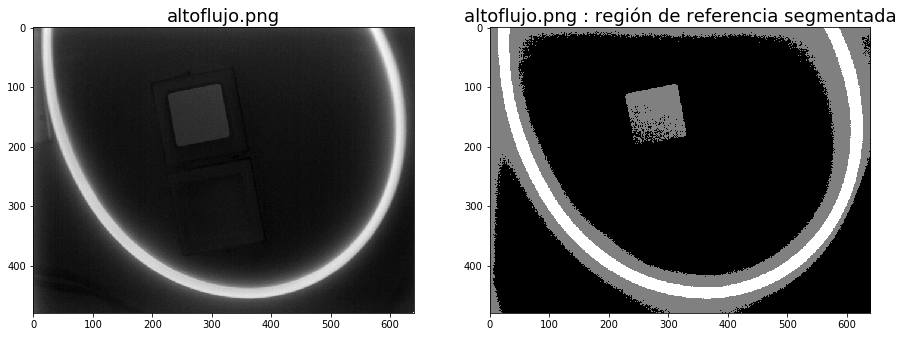

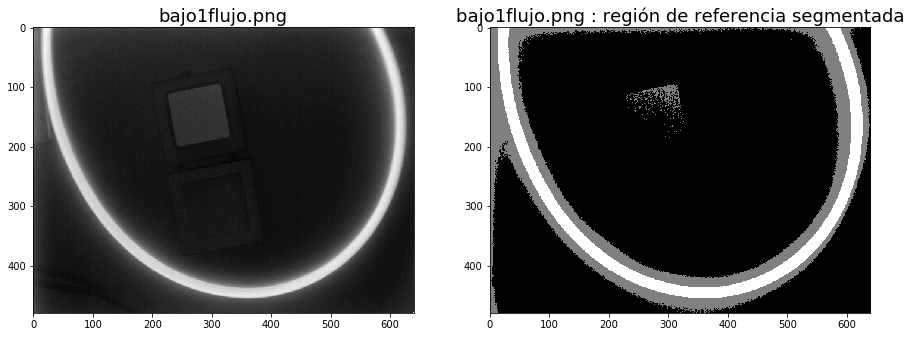

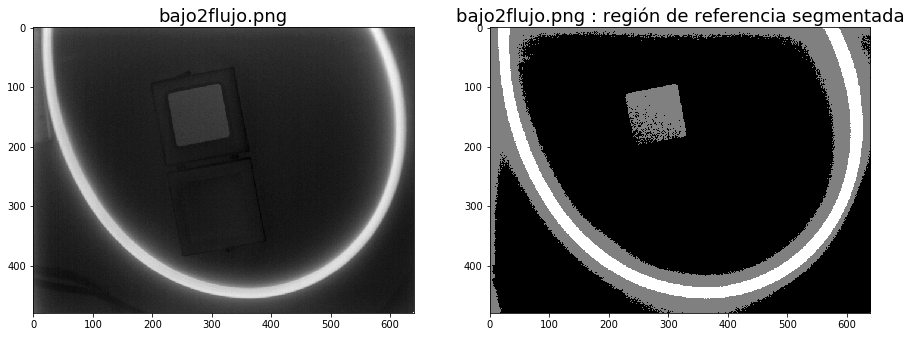

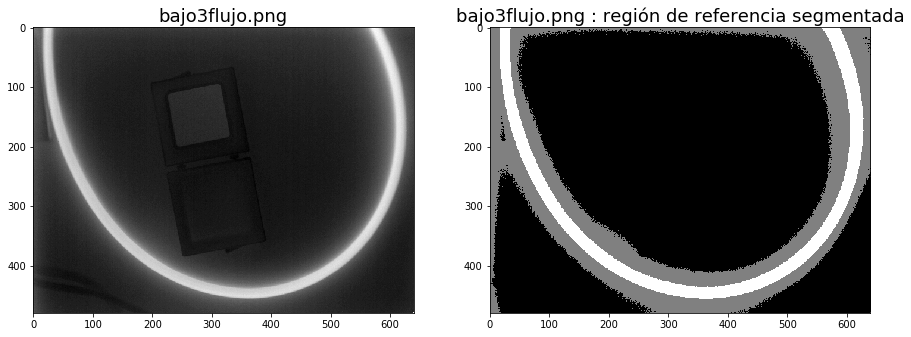

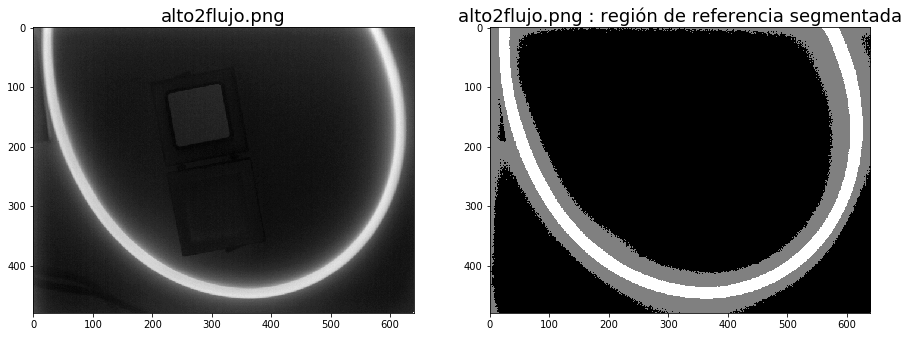

In [18]:
for nombre in mangueras.keys():
    utils.side_by_side(
        mangueras[nombre], region_ref1[nombre], 
        title1=nombre, title2=f"{nombre} : región de referencia segmentada"
    )

Aquí podemos observar que la referencia es más difícil de segmentar en función de las intensidades. 

La función fue llamada indicando que se buscaba una imagen trinaria ```auto_seg(img, groups=3)```
Se esperaba que esto permitiese segmentar la **región referencia** ya que ésta muestra una intensidad mayor a la del fondo pero menor a la de la manguera.

Tal vez quitando la región de la manguera (la de mayor intensidad) sea más fácil segmentar automáticamente la **región referencia**.

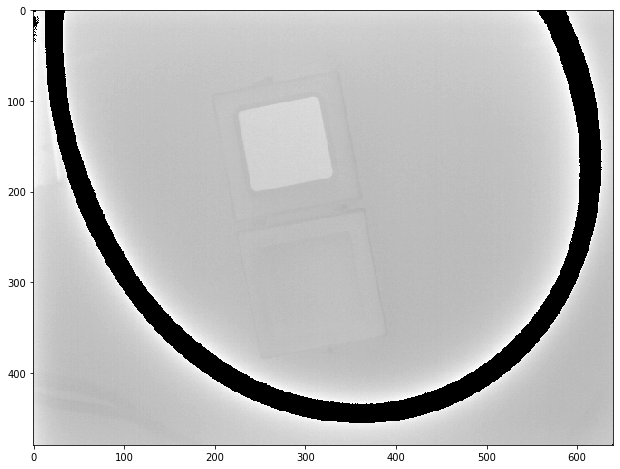

In [19]:
sin_manguera = {
    key: mangueras[key] * np.uint8(1.0 - mangueras_segmentadas[key])
    for key in mangueras_segmentadas.keys()
}
plt.imshow(sin_manguera[llaves[0]], cmap='gray')

Nótese que la imagen muestra en negro la región que antes mostraba la mayor intensidad.

In [20]:
sin_manguera = {
    key: mangueras[key] * np.uint8(1.0 - mangueras_segmentadas[key])
    for key in mangueras_segmentadas.keys()
}

In [21]:
region_ref2 = {
    key: auto_segment(sin_manguera[key], groups=2, nonzero=True) for key in sin_manguera.keys()
}

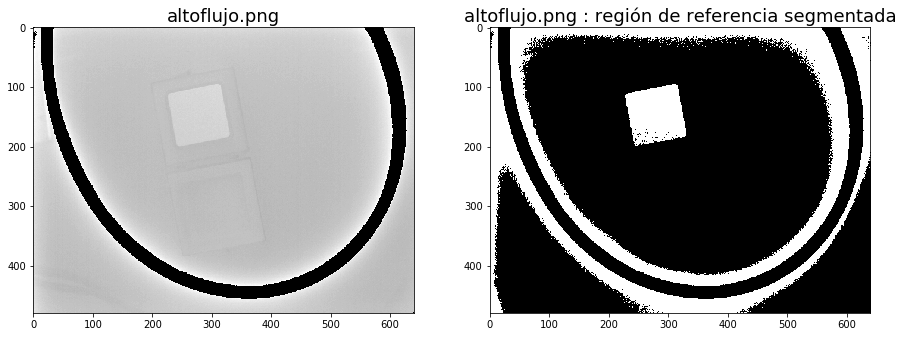

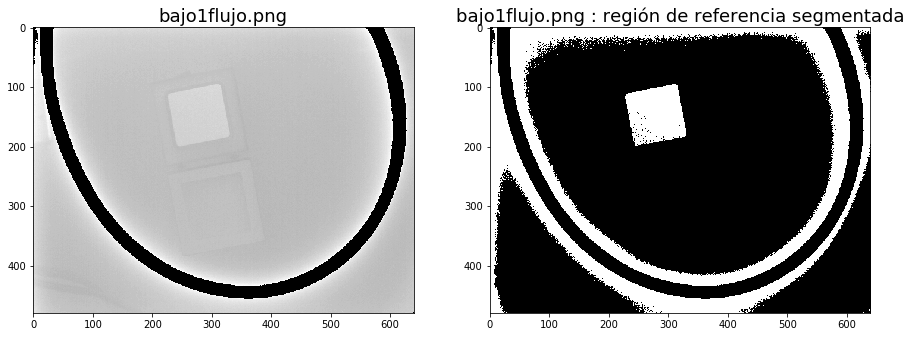

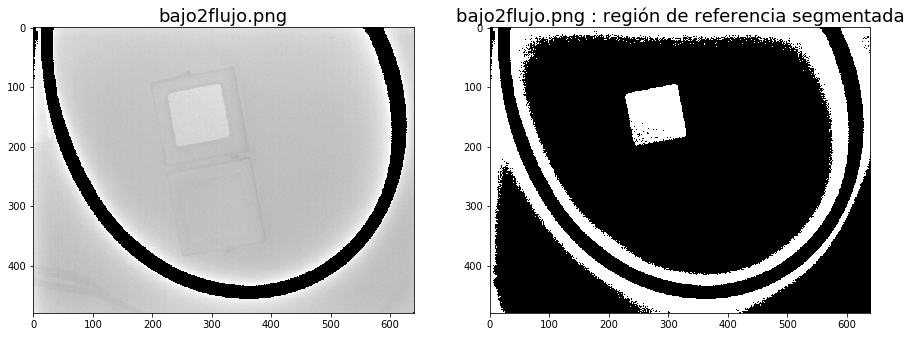

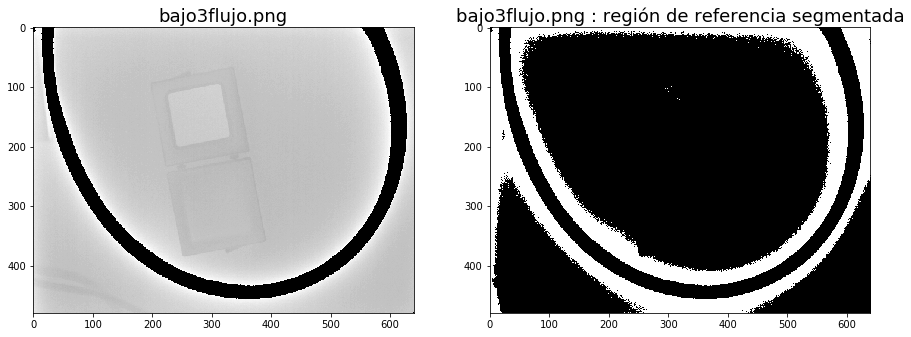

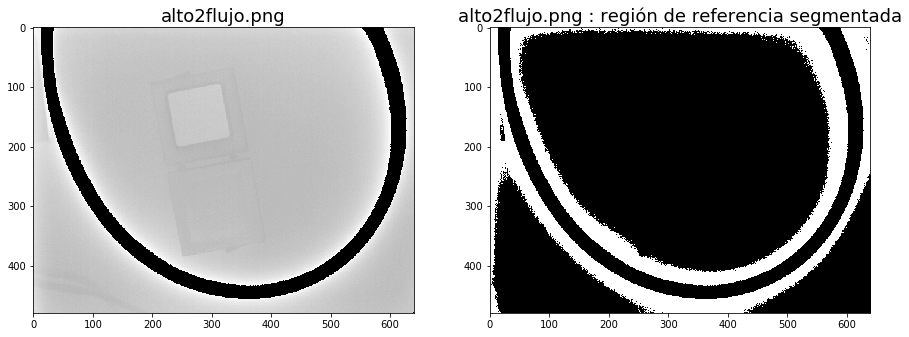

In [22]:
for nombre in sin_manguera.keys():
    utils.side_by_side(
        sin_manguera[nombre], region_ref2[nombre], 
        title1=nombre, title2=f"{nombre} : región de referencia segmentada"
    )

Aún teniendo la región de la manguera oscurecida, la función ```auto_seg()``` no permite segmentar la **región referencia** de forma automática. Esto podría atribuirse a que la forma del histograma de las ***imágenes con la manguera oscurecida*** sigue mostrando dos cúmulos principales como se muestra a continuación.

Sin embargo, debe notarse que la funcción ```auto_seg(.., nonzero=True)``` fue llamada con el parámetro ```nonzero=True```, lo que hace que la funcón ignore las entradas que valen 0 al momento de calcular los centros de los grupos.

Si se desea una visualización más detallada del funcionamiento de este parámetro, se recomienda correr este código, en dos celdas por separado para observar el efecto del parámetro ```nonzero``` :
```python
region_ref2 = {
    key: auto_segment(sin_manguera[key], groups=2, nonzero=True, verbose=True) for key in sin_manguera.keys()
}
```
por
```python
region_ref2 = {
    key: auto_segment(sin_manguera[key], groups=2, nonzero=False, verbose=True) for key in sin_manguera.keys()
}
```

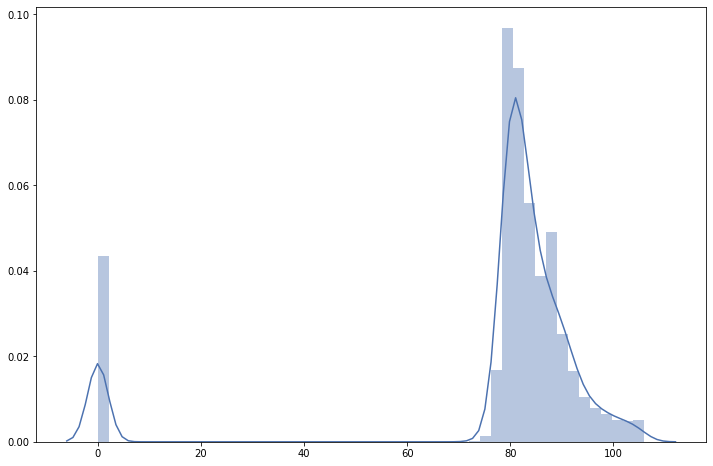

In [23]:
sns.distplot(sin_manguera[llaves[2]].flatten())

In [24]:
region_ref3 = {
    key: auto_segment(sin_manguera[key], groups=3, nonzero=True) for key in sin_manguera.keys()
}

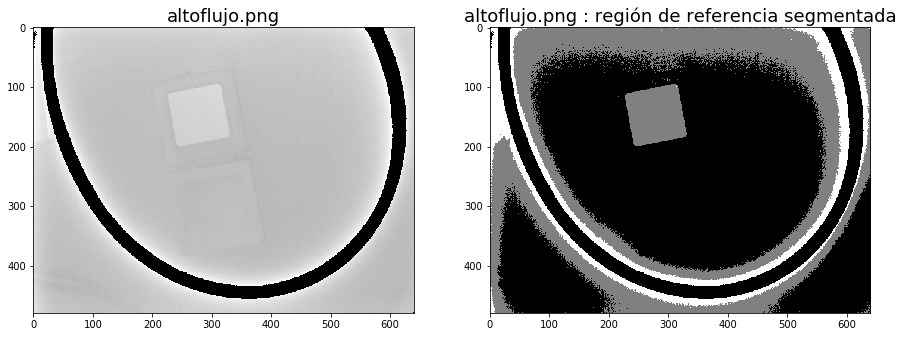

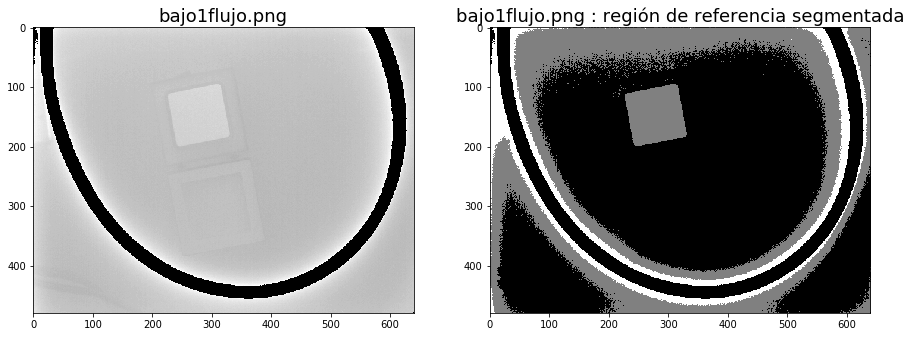

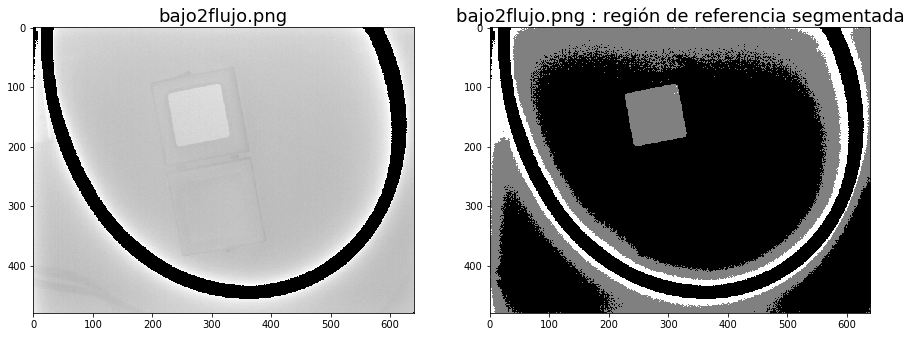

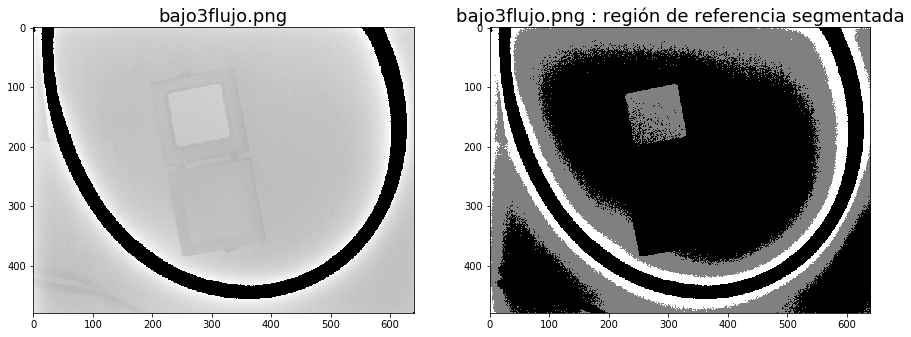

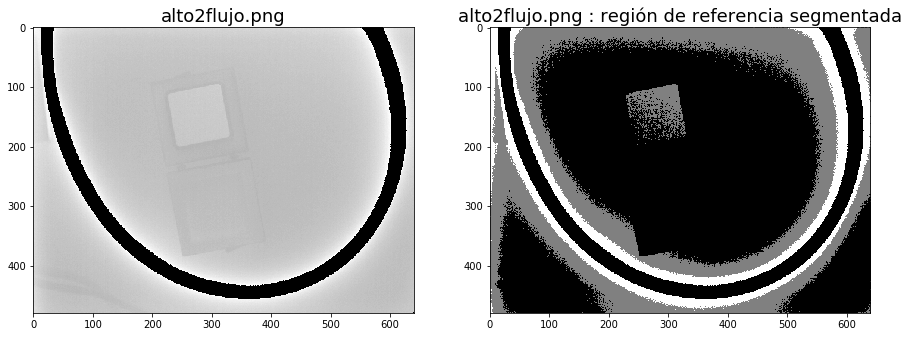

In [25]:
for nombre in sin_manguera.keys():
    utils.side_by_side(
        sin_manguera[nombre], region_ref3[nombre], 
        title1=nombre, title2=f"{nombre} : región de referencia segmentada"
    )

In [26]:
edges = canny(mangueras[llaves[0]] /255.)
fill_coins = ndi.binary_fill_holes(edges)

In [27]:
verbose = False

if verbose:
    for img1 in mangueras.values():
        ref_region(img1, verbose=True)

In [28]:
region_ref4 = {
    key: ref_region(mangueras[key]) for key in mangueras.keys()
}

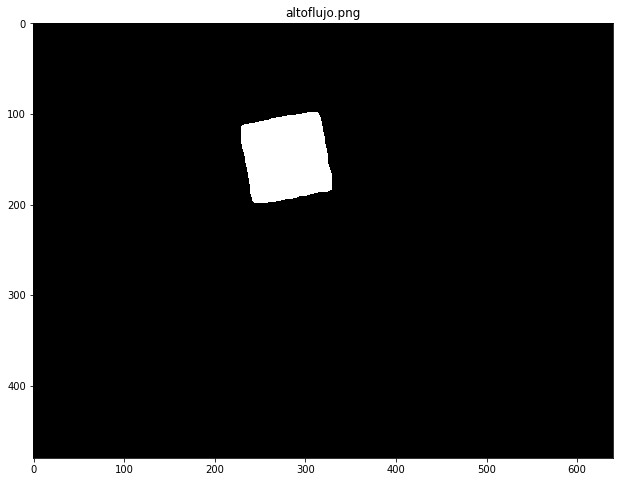

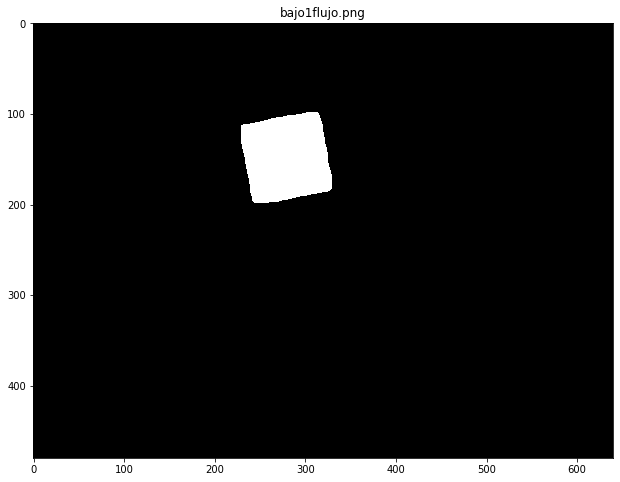

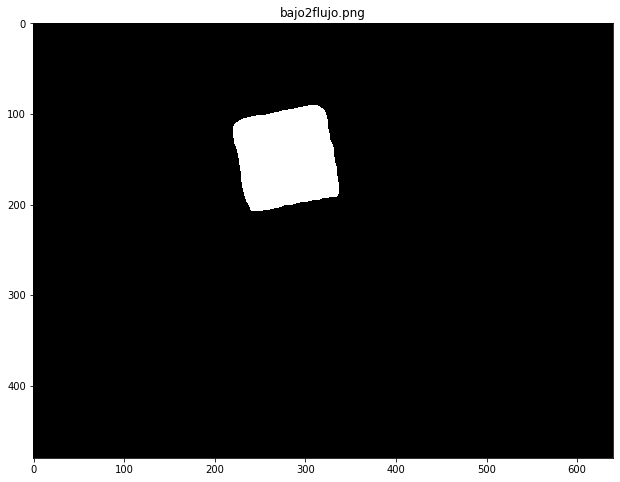

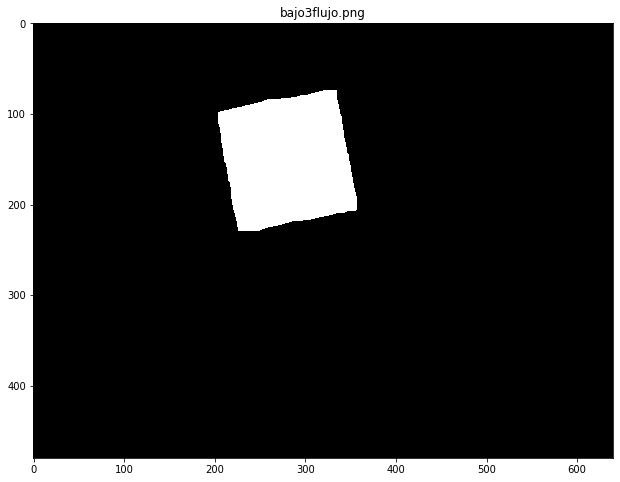

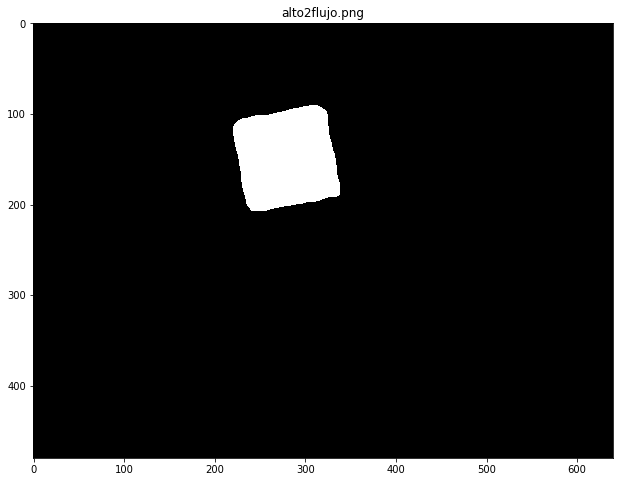

In [29]:
for nombre, imagen in zip(region_ref4.keys(), region_ref4.values()):
    plt.figure()
    plt.imshow(np.uint8(imagen), cmap="gray")
    plt.title(nombre)

In [30]:
segmented_ref_reg = {
    key: mangueras[key] * region_ref4[key] for key in llaves
}

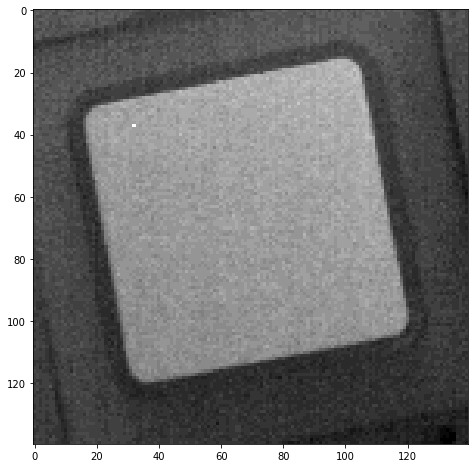

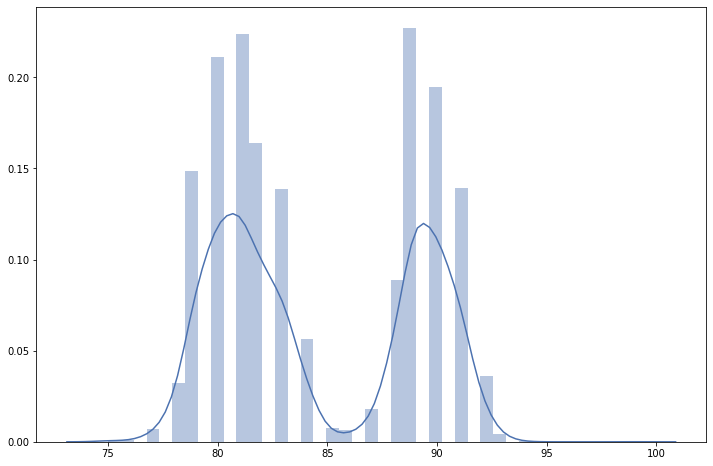

In [31]:

_tmp = copy.deepcopy(mangueras[llaves[0]][80:220, 210:350])
#_tmp[ _tmp < 85] = 0
#_tmp *= np.uint8( auto_segment(_tmp) * 255 )
plt.imshow(_tmp, cmap='gray')
plt.figure()
sns.distplot(_tmp.flatten()[_tmp.flatten().nonzero()])


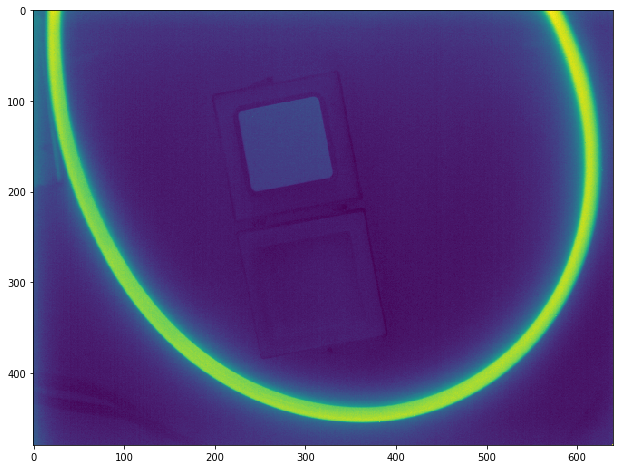

In [32]:
plt.imshow(mangueras[llaves[0]])

In [33]:
#_tmp = mangueras[llaves[0]][90:210, 200:350]
#_tmp = auto_segment(_tmp)
#plt.imshow(_tmp, cmap='gray')
#plt.figure()
#sns.distplot(mangueras[llaves[0]][_tmp.nonzero()].flatten())

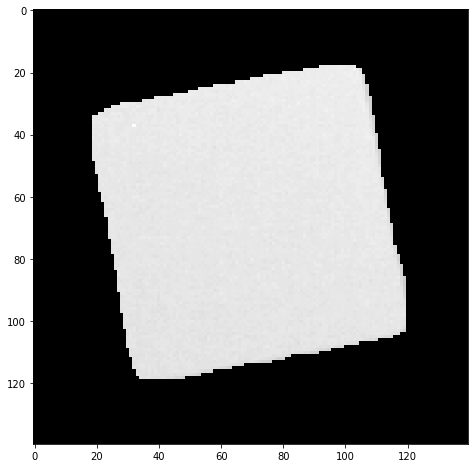

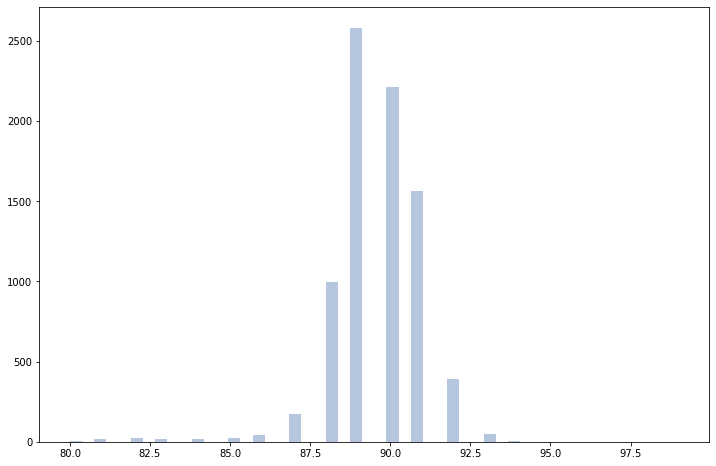

In [34]:
_tmp = copy.deepcopy(segmented_ref_reg[llaves[0]][80:220, 210:350])
plt.imshow(_tmp, cmap='gray')
plt.figure()
sns.distplot(_tmp[ _tmp != 0].flatten(), kde=False)


In [35]:
# Esto servía, pero ya no :
"""
region_info = pd.core.frame.DataFrame({
    f"{key.replace('.png', '')} ": value[ value != 0 ].flatten() for key, value in segmented_ref_reg.items() 
})
region_info.describe()
"""

'\nregion_info = pd.core.frame.DataFrame({\n    f"{key.replace(\'.png\', \'\')} ": value[ value != 0 ].flatten() for key, value in segmented_ref_reg.items() \n})\nregion_info.describe()\n'

In [36]:
region_info_list = list(map(
    lambda x, y: pd.core.series.Series(x[ x != 0].flatten(), name=y), segmented_ref_reg.values(), segmented_ref_reg.keys()
))
region_info = pd.concat(region_info_list, axis=1)

In [37]:
region_info.describe()

altoflujo.png  bajo1flujo.png  bajo2flujo.png  bajo3flujo.png  \
count    8111.000000     8144.000000    10736.000000    18376.000000   
mean       89.573172       89.296537       87.485190       82.928766   
std         1.410561        1.432713        4.179704        3.440137   
min        80.000000       79.000000       77.000000       76.000000   
25%        89.000000       89.000000       87.000000       80.000000   
50%        90.000000       89.000000       89.000000       82.000000   
75%        90.000000       90.000000       90.000000       86.000000   
max        99.000000       99.000000       98.000000       95.000000   

       alto2flujo.png  
count    10839.000000  
mean        84.963927  
std          3.245888  
min         76.000000  
25%         84.000000  
50%         86.000000  
75%         87.000000  
max         96.000000

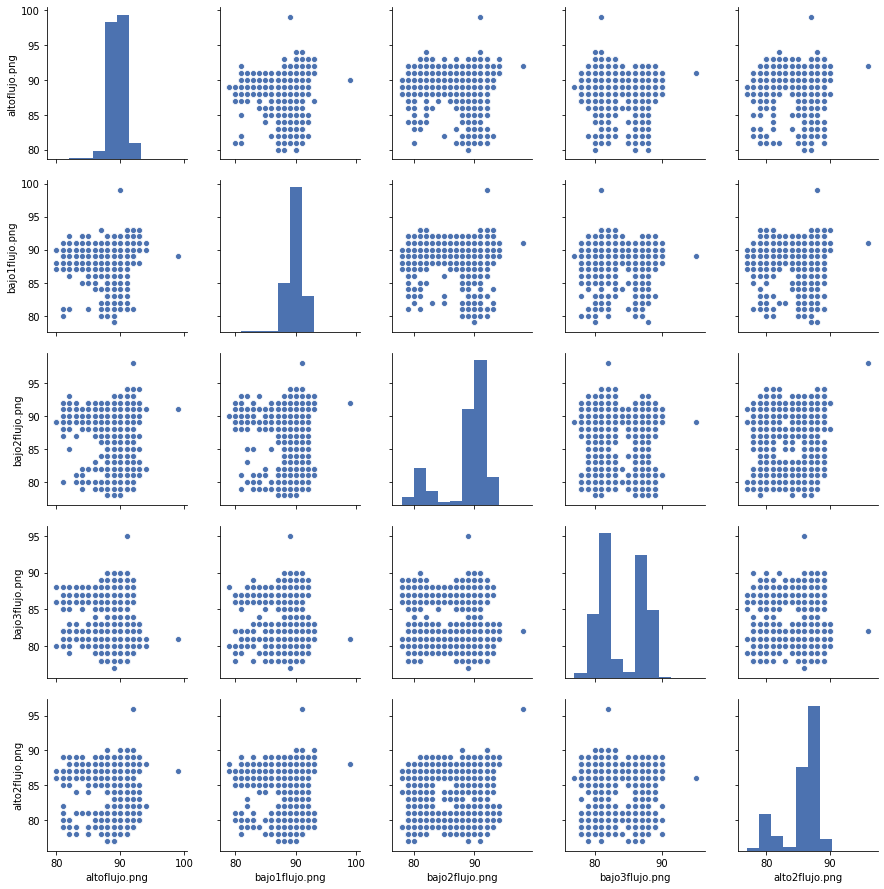

In [39]:
# Relatively slow, avoid running :
sns.pairplot(region_info.dropna())

In [40]:
preg4 = skeletonize(mangueras_segmentadas[llaves[0]])

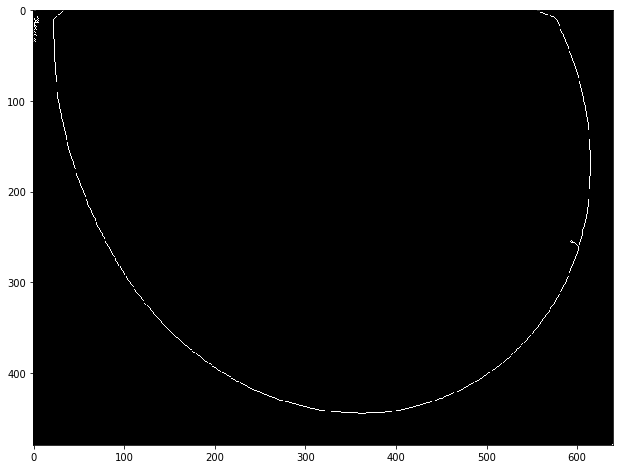

In [41]:
plt.imshow(preg4, cmap='gray')

6


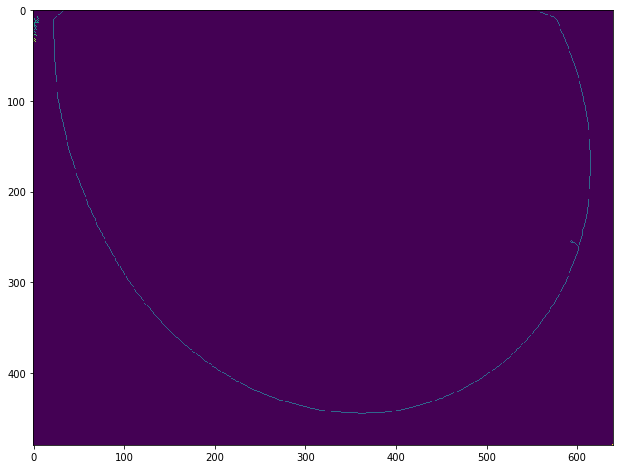

In [155]:
label_image, n_objs = label(preg4, return_num=True) #connectivity=1,
plt.imshow(label_image)
print(n_objs)

In [72]:
#help(label)

In [92]:
objs = regionprops(label_image)

In [93]:
objs = regionprops(label_image) 
for obj in objs:
    print(obj.area)

3
1135
34
4
6
1


In [156]:
_largest = reduce(lambda x, y: x if x.area > y.area else y, objs)

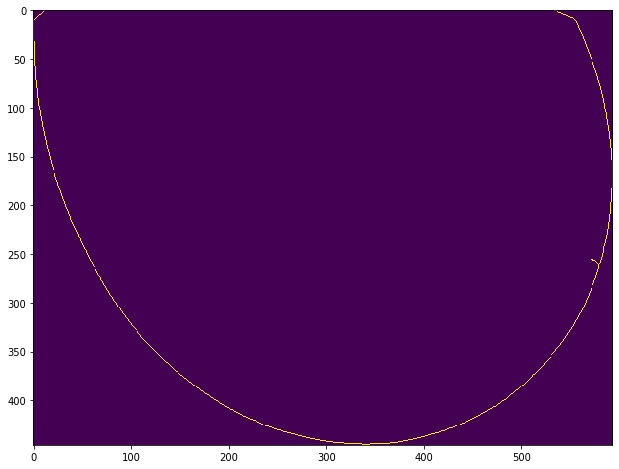

In [157]:
plt.imshow(_largest.image)

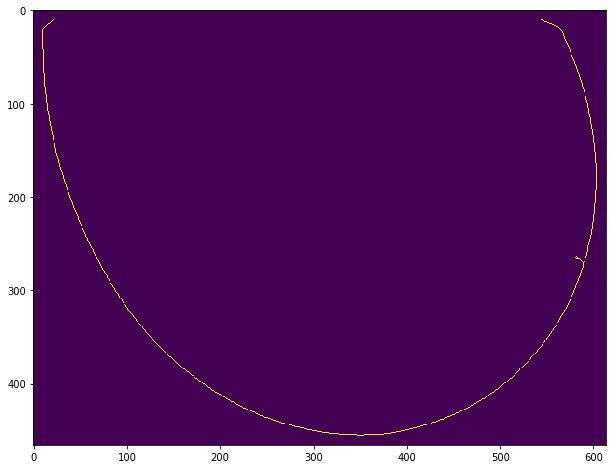

In [140]:
el_obj = objs[1] 
plt.imshow(pad_obj(el_obj))
#plt.imshow( mangueras_adelgazadas[ objs[1].image.nonzero()[0].flatten() ] )

In [141]:
len(max_tree(pad(el_obj.image))[1])

286124

In [104]:
mangueras[llaves[0]].shape
480*640

307200

In [144]:
el_obj_pad = pad(el_obj.image)

In [145]:
help(el_obj)

Help on RegionProperties in module skimage.measure._regionprops object:

class RegionProperties(builtins.object)
 |  RegionProperties(slice, label, label_image, intensity_image, cache_active)
 |  
 |  Please refer to `skimage.measure.regionprops` for more information
 |  on the available region properties.
 |  
 |  Methods defined here:
 |  
 |  __eq__(self, other)
 |      Return self==value.
 |  
 |  __getitem__(self, key)
 |  
 |  __init__(self, slice, label, label_image, intensity_image, cache_active)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __iter__(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  area
 |      Number of pixels of the region.
 |  
 |  bbox
 |      Bounding box ``(min_row, min_col, max_row, max_col)

[ 0 33]
[  0 556]
[  0 557]
[  0 558]
[ 1 32]
[  1 559]
[ 2 31]
[  2 560]
[  2 561]
[  2 562]
[ 3 30]
[  3 563]
[  3 564]
[ 4 28]
[ 4 29]
[  4 565]
[  4 566]
[  4 567]
[ 5 27]
[  5 568]
[  5 569]
[ 6 26]
[  6 570]
[  6 571]
[ 7 25]
[  7 572]
[  7 573]
[  7 574]
[ 8 24]
[  8 575]
[ 9 23]
[  9 576]
[10 22]
[ 10 577]
[11 22]
[ 11 578]
[12 22]
[ 12 578]
[13 22]
[ 13 579]
[14 22]
[ 14 579]
[15 22]
[ 15 580]
[16 22]
[ 16 580]
[17 22]
[ 17 580]
[18 22]
[ 18 581]
[19 22]
[ 19 581]
[20 22]
[ 20 581]
[21 22]
[ 21 582]
[22 22]
[ 22 582]
[23 22]
[ 23 583]
[24 22]
[ 24 583]
[25 22]
[ 25 584]
[26 22]
[ 26 584]
[27 22]
[ 27 585]
[28 22]
[ 28 585]
[29 22]
[ 29 585]
[30 22]
[ 30 586]
[31 22]
[ 31 586]
[32 23]
[ 32 587]
[33 23]
[ 33 587]
[34 23]
[ 34 587]
[35 23]
[ 35 588]
[36 23]
[ 36 588]
[37 23]
[ 37 588]
[38 23]
[ 38 589]
[39 23]
[ 39 589]
[40 23]
[ 40 590]
[41 23]
[ 41 590]
[42 23]
[ 42 590]
[43 23]
[ 43 591]
[44 23]
[ 44 591]
[45 23]
[ 45 592]
[46 23]
[ 46 592]
[47 23]
[ 47 592]
[48 23]
[ 48 593]


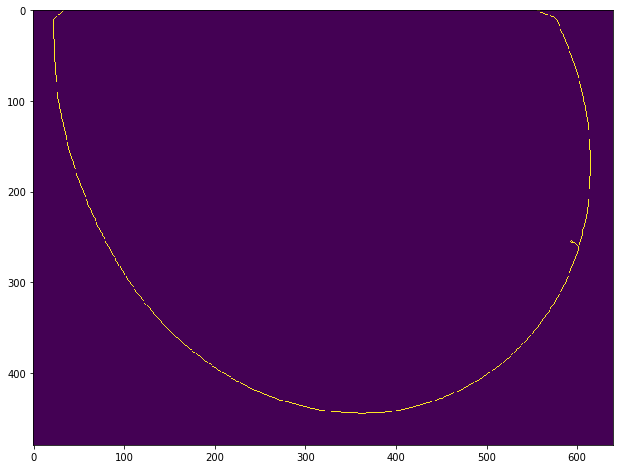

In [245]:
_hola = np.zeros_like(preg4)
for coord in el_obj.coords:
    print(coord)
    i, j = coord
    #print(mangueras_segmentadas[llaves[0]][(i, j)])
    _hola[(i, j)] = 1
#plt.imshow(_hola[200:300, 550:650])
plt.imshow(_hola)

In [232]:
find_branch_points(_hola).sum()

0

In [235]:
def max_skeleton(img: np.ndarray):
    """
    """
    
    # Find the sekeleton of the image :
    _skeleton = skeletonize(img)
    # Label each region of the skeleton :
    _label_image = label(_skeleton, return_num=False)
    # Get the properties of each label :
    _objs = regionprops(_label_image)
    # Keep only the skeleton which has the most pixels :
    _largest = reduce(lambda x, y: x if x.area > y.area else y, _objs)
    
    _largest_on_image = np.zeros_like(img, dtype=img.dtype)
    for _coord in _largest.coords:
        i, j = _coord
        _largest_on_image[(i, j)] = 1
    
    # Call the pruning function
    
    return _largest_on_image
    

In [267]:
def get_neighbours(p, exclude_p=True, shape=None):
    """
        Snippet taken from :
        https://stackoverflow.com/questions/34905274/how-to-find-the-neighbors-of-a-cell-in-an-ndarray
        
        Little example :
        p = np.r_[4, 5]
        shape = (6, 6)

        neighbours = get_neighbours(p, shape=shape)

        x = np.zeros(shape, int)
        x[tuple(neighbours.T)] = 1
        x[tuple(p)] = 2

        print(x)
        # [[0 0 0 0 0 0]
        #  [0 0 0 0 0 0]
        #  [0 0 0 0 0 0]
        #  [0 0 0 0 1 1]
        #  [0 0 0 0 1 2]
        #  [0 0 0 0 1 1]]
    """
    ndim = len(p)

    # generate an (m, ndims) array containing all strings over the alphabet {0, 1, 2}:
    offset_idx = np.indices((3,) * ndim).reshape(ndim, -1).T

    # use these to index into np.array([-1, 0, 1]) to get offsets
    offsets = np.r_[-1, 0, 1].take(offset_idx)

    # optional: exclude offsets of 0, 0, ..., 0 (i.e. p itself)
    if exclude_p:
        offsets = offsets[np.any(offsets, 1)]

    neighbours = p + offsets    # apply offsets to p

    # optional: exclude out-of-bounds indices
    if shape is not None:
        valid = np.all((neighbours < np.array(shape)) & (neighbours >= 0), axis=1)
        neighbours = neighbours[valid]

    return neighbours

In [284]:
split_nodes: list = []
    
for point in el_obj.coords:
    _neighbours = 0
    for nei in get_neighbours(point, shape=preg4.shape):
        i, j = nei
        _neighbours += preg4[(i,j)]
    if _neighbours > 2:
        split_nodes.append(point)

print(split_nodes)

[array([255, 595]), array([256, 594]), array([256, 595]), array([256, 596]), array([260, 601])]


In [292]:
for point in split_nodes:
    print(point)
    for nei in get_neighbours(point, shape=preg4.shape):
        print('\t', nei, preg4[tuple(nei)])
    print('\n')

[255 595]
	 [254 594] True
	 [254 595] False
	 [254 596] False
	 [255 594] False
	 [255 596] False
	 [256 594] True
	 [256 595] True
	 [256 596] True


[256 594]
	 [255 593] True
	 [255 594] False
	 [255 595] True
	 [256 593] False
	 [256 595] True
	 [257 593] False
	 [257 594] False
	 [257 595] False


[256 595]
	 [255 594] False
	 [255 595] True
	 [255 596] False
	 [256 594] True
	 [256 596] True
	 [257 594] False
	 [257 595] False
	 [257 596] False


[256 596]
	 [255 595] True
	 [255 596] False
	 [255 597] False
	 [256 595] True
	 [256 597] True
	 [257 595] False
	 [257 596] False
	 [257 597] False


[260 601]
	 [259 600] True
	 [259 601] False
	 [259 602] True
	 [260 600] False
	 [260 602] False
	 [261 600] False
	 [261 601] True
	 [261 602] False




In [248]:
def thinning(img: np.ndarray, se: np.ndarray) -> np.ndarray:
    """
    """
    
    return  np.bitwise_xor(img, ndi.binary_hit_or_miss(img, se))


def prune(img: np.ndarray, n: int = 1):
    """
    """
    
     # Construct all of the structuring elements needed from clockwise rotations.
    clockwise_rotations = lambda y: [y] + list(map(lambda x: np.rot90(y, x), reversed(range(1, 3+1))))
    _b1 = np.array([[0, 0, 0],[1, 1, 0],[0, 0, 0]], dtype=img.dtype)
    _b2 = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 0]], dtype=img.dtype)
    B = reduce(
        lambda x, y: x + y, 
        lmap(clockwise_rotations, [_b1, _b2])
    )
    H = np.ones((3, 3))
    
    # Thinning, by all of the structuring elements :
    
    X1 = reduce(thinning, n*B, img)
    #while n > 1:
    #    X1 = reduce(thinning, B, X1)
    
    return X1
    
    # Hit or miss stage :
    #X2 = reduce(ndi.binary_hit_or_miss, B, X1)

    #return X2
    
    # Dilation stage : 
    #X3 = cv.dilate(X2, H)
    # Hit-or-miss
    #ndi.binary_hit_or_miss
    
    
##

In [253]:
pruned = prune(_hola, n=15)
pruned.nonzero()

(array([ 11,  12,  13, ..., 445, 445, 445]),
 array([578, 578, 579, ..., 364, 365, 366]))

In [264]:
neighbours = lambda image, pos: pad1( image[max(0, pos[0]-1):min(pos[0]+1, image.shape[0]), max(0, pos[1]-1):min(pos[1]+1, image.shape[1])]  )

In [265]:
neighbours(np.array([[0, 1, 0],[0, 1, 0],[1, 0, 1]]), (1, 2))

array([[0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.]])

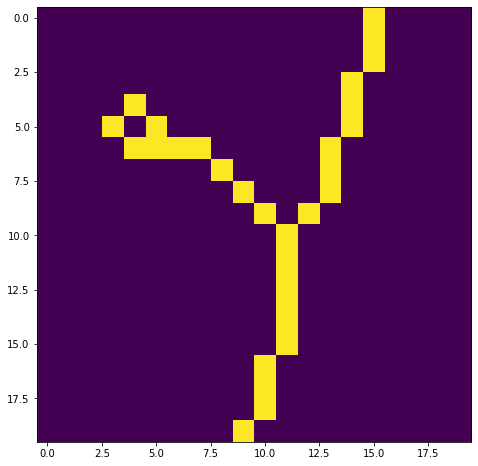

In [260]:
plt.imshow(pruned[:270, 590:610])

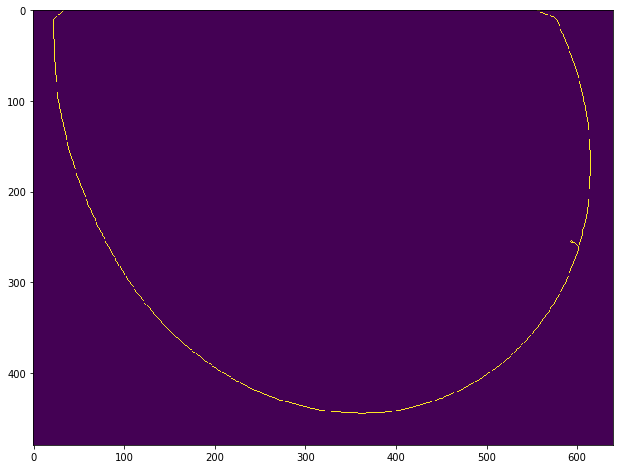

In [175]:
plt.imshow(max_skeleton(mangueras_segmentadas[llaves[0]]))

In [111]:
las_dimensiones = variable1.shape

In [164]:
x = mangueras[llaves[0]].dtype

In [165]:
x(5.4)

TypeError: 'numpy.dtype' object is not callable

In [112]:
no_me_importa, si_me_importa = max_tree(variable1)

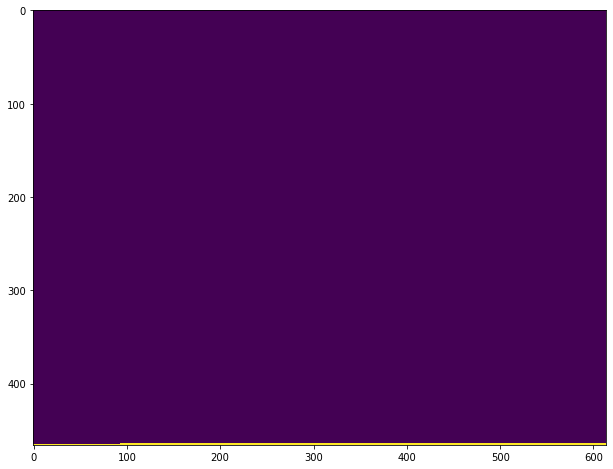

In [114]:
plt.imshow(variable1.flatten()[si_me_importa].reshape(las_dimensiones))

In [45]:
def segplot(
    img: np.ndarray, 
    group: skimage.measure._regionprops.RegionProperties, 
    color: Optional[str] = None,
    title: Optional[str] = None
) -> NoReturn:
    """
    """
    if not color:
        color = 'red'
        
    fig, ax = plt.subplots(figsize=(9, 9))
    ax.imshow(img, cmap='gray')

    try:
        iter(group)
        for region in group:
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor=color, linewidth=2)
            ax.add_patch(rect)
    except:
        minr, minc, maxr, maxc = group.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                 fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(rect)
        
    
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()
##

def watershed_viz(image, distance, labels):
    """
        Constructed from the example found in :
        https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html
    """
    fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Overlapping objects')
    ax[1].imshow(-distance, cmap=plt.cm.gray)
    ax[1].set_title('Distances')
    ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
    ax[2].set_title('Separated objects')

    for a in ax:
        a.set_axis_off()

    fig.tight_layout()
    plt.show()
##

def ez_watershed(
    image: np.ndarray, 
    markers: Optional[int] = None, 
    footprint: Optional[np.array] = None, 
    **kw
) -> Tuple[int, int, int]:
    """
    """
    distance = ndi.distance_transform_edt(image)
    if footprint is not None:
        fp = footprint
    else:
        fp = np.ones((10, 10))
    
    if markers is None:
        local_maxi = peak_local_max(
            distance, 
            indices=False, 
            footprint=np.ones((10, 10)),
            labels=image,
            **kw
        )
        markers = ndi.label(local_maxi)[0]

    labels  = watershed(-distance, markers, mask=image)
    
    return markers, distance, labels
##

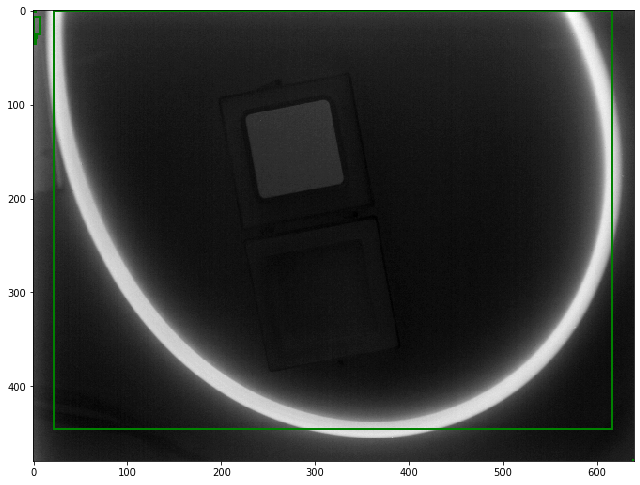

In [74]:
segplot(mangueras[llaves[0]], objs, color='green')

In [47]:
def try_iter(foo):
    try:
        iter(foo)
    except:
        print('No iterable amigou')

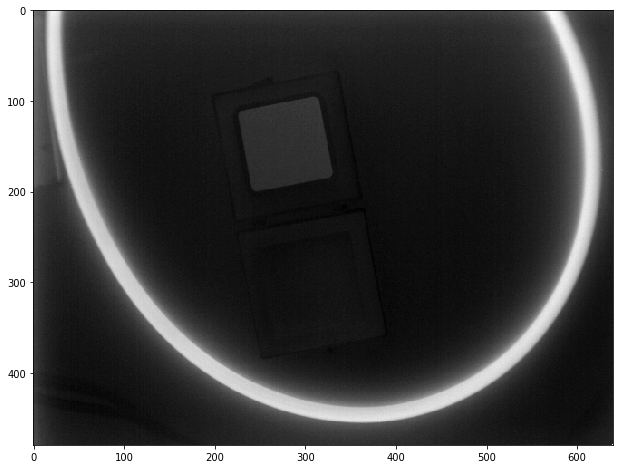

In [48]:
plt.imshow(cv.erode(mangueras[llaves[0]], np.ones((1, 1))), cmap='gray')

In [66]:
#_se = np.ones((10,10))
#_se = disk(1)
#thin(cv.erode(manguera, _se))
mangueras_adelgazadas = {
    nombre: skeletonize(manguera) for nombre, manguera in mangueras_segmentadas.items()
}

<Figure size 864x576 with 0 Axes>

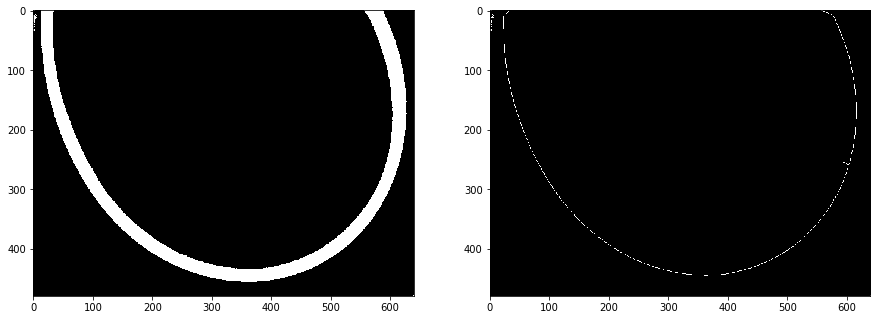

<Figure size 864x576 with 0 Axes>

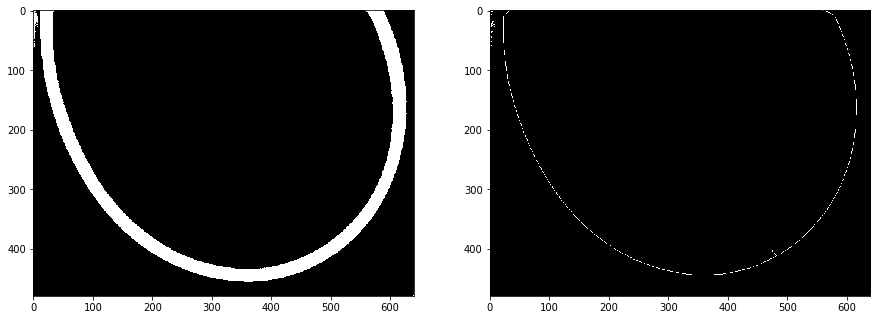

<Figure size 864x576 with 0 Axes>

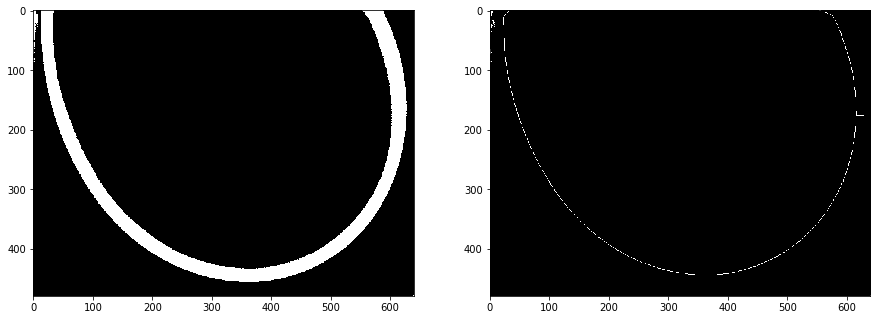

<Figure size 864x576 with 0 Axes>

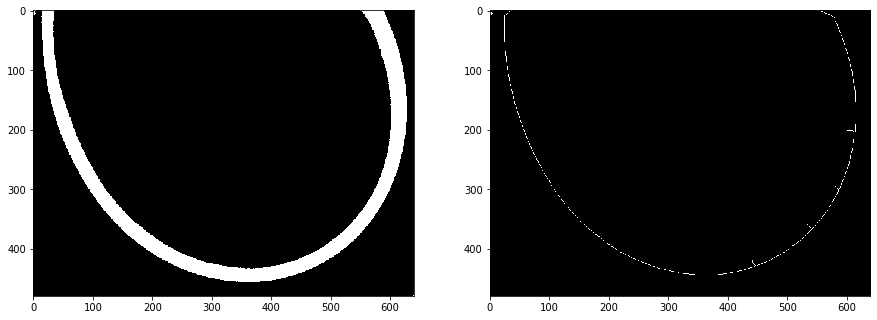

<Figure size 864x576 with 0 Axes>

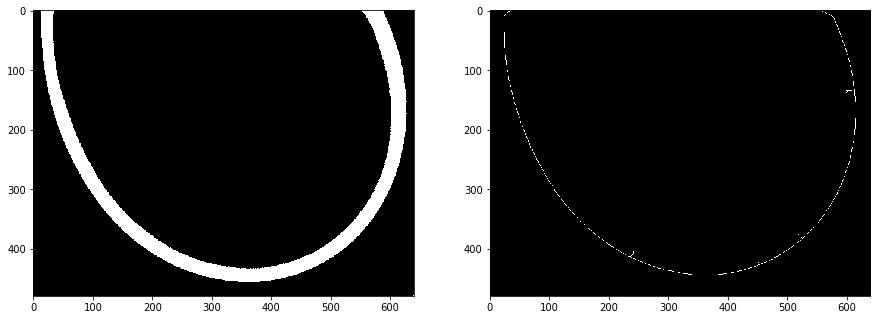

In [58]:
for manguera, esqueleto in zip(mangueras_segmentadas.values(), mangueras_adelgazadas.values()):
    plt.figure()
    utils.side_by_side(manguera, esqueleto, cmap='gray')
    #mfs.img_surf(manguera)

for manguera in mangueras_segmentadas.values():
    markers, distance, labels = ez_watershed(manguera, markers=3)
    print(markers)
    watershed_viz(manguera, distance, labels)

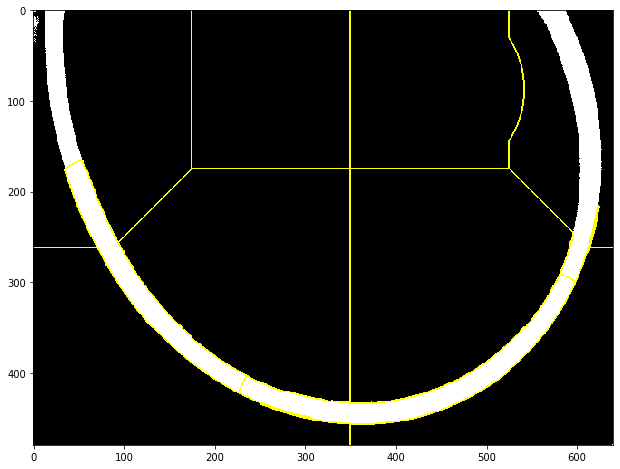

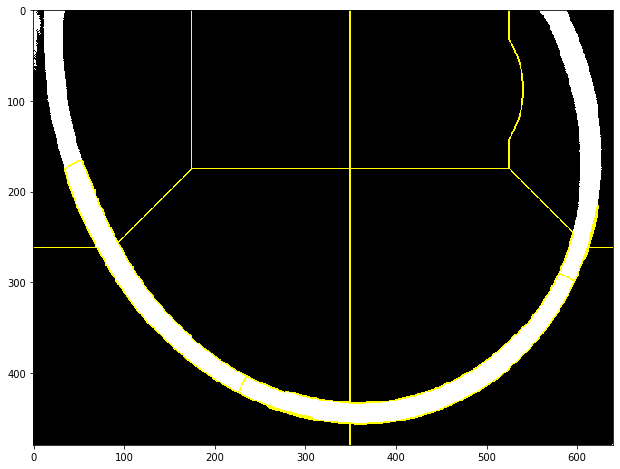

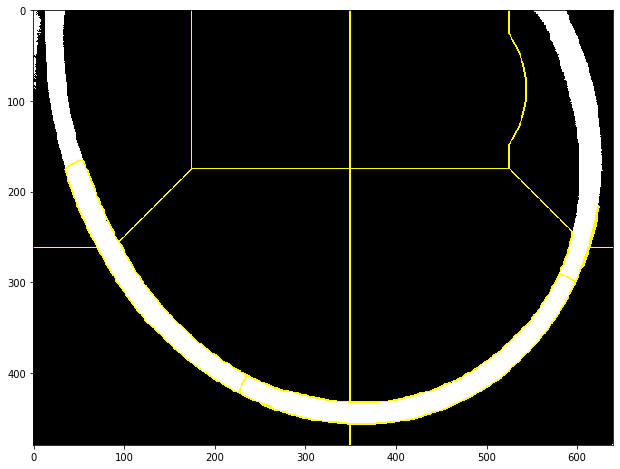

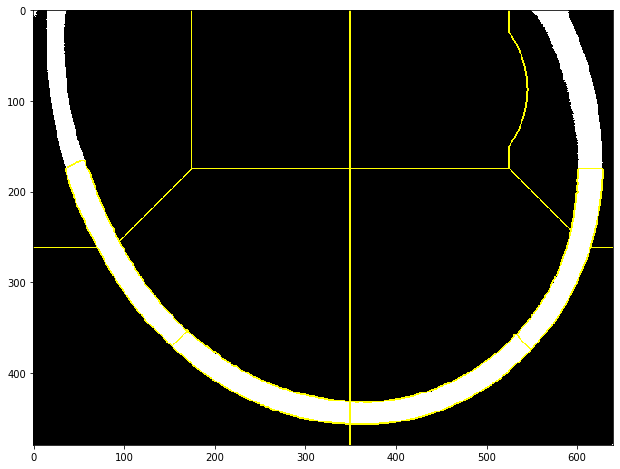

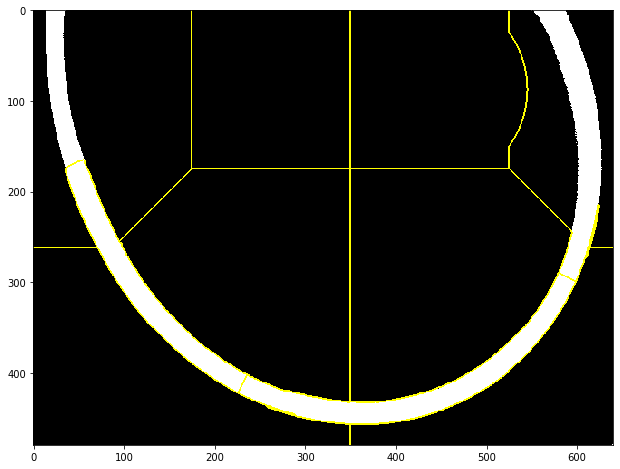

In [45]:
for manguera in mangueras_segmentadas.values():
    #segments_slic = slic(manguera, n_segments=4, compactness=10, sigma=1)
    segments_watershed = watershed(sobel(manguera), markers=10, compactness=0.001)
    plt.figure()
    plt.imshow(mark_boundaries(manguera, segments_watershed))

In [46]:
help(watershed)

Help on function watershed in module skimage.morphology.watershed:

watershed(image, markers=None, connectivity=1, offset=None, mask=None, compactness=0, watershed_line=False)
    Find watershed basins in `image` flooded from given `markers`.
    
    Parameters
    ----------
    image: ndarray (2-D, 3-D, ...) of integers
        Data array where the lowest value points are labeled first.
    markers: int, or ndarray of int, same shape as `image`, optional
        The desired number of markers, or an array marking the basins with the
        values to be assigned in the label matrix. Zero means not a marker. If
        ``None`` (no markers given), the local minima of the image are used as
        markers.
    connectivity: ndarray, optional
        An array with the same number of dimensions as `image` whose
        non-zero elements indicate neighbors for connection.
        Following the scipy convention, default is a one-connected array of
        the dimension of the image.
    of

In [47]:
help(medial_axis)

Help on function medial_axis in module skimage.morphology._skeletonize:

medial_axis(image, mask=None, return_distance=False)
    Compute the medial axis transform of a binary image
    
    Parameters
    ----------
    image : binary ndarray, shape (M, N)
        The image of the shape to be skeletonized.
    mask : binary ndarray, shape (M, N), optional
        If a mask is given, only those elements in `image` with a true
        value in `mask` are used for computing the medial axis.
    return_distance : bool, optional
        If true, the distance transform is returned as well as the skeleton.
    
    Returns
    -------
    out : ndarray of bools
        Medial axis transform of the image
    dist : ndarray of ints, optional
        Distance transform of the image (only returned if `return_distance`
        is True)
    
    See also
    --------
    skeletonize
    
    Notes
    -----
    This algorithm computes the medial axis transform of an image
    as the ridges of its 

In [80]:
intensities2 = pd.core.frame.DataFrame({
    key: reg_ref_segmentadas[key].flatten() for key in reg_ref_segmentadas.keys()
})

In [101]:
"""kmeans2 = KMeans(
    n_clusters=2, 
    random_state=0, 
    verbose=False
).fit(
    intensities2.
)"""

'kmeans2 = KMeans(\n    n_clusters=2, \n    random_state=0, \n    verbose=False\n).fit(\n    intensities2.\n)'

In [93]:
seg = mangueras[llaves[0]] * 

In [98]:
seg.max(), mangueras[llaves[0]].max(), mangueras_segmentadas[llaves[0]].max()

(152, 152, 1)

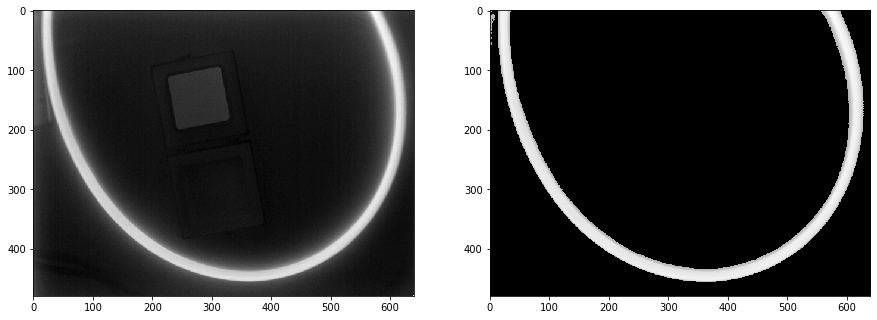

In [99]:
utils.side_by_side(mangueras[llaves[0]], seg)

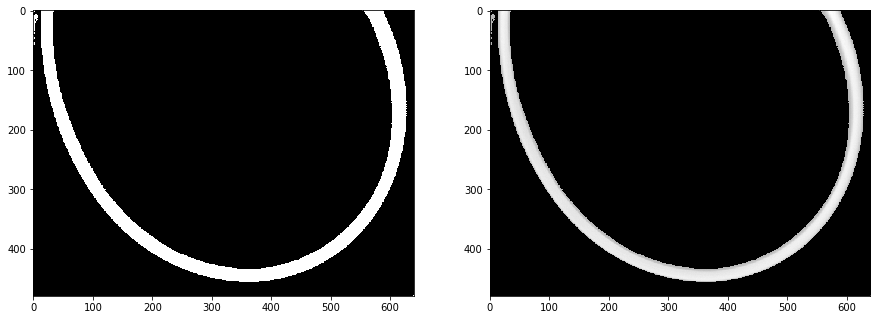

In [100]:
utils.side_by_side(mangueras_segmentadas[llaves[0]], seg)

In [108]:
mangueras_segmentadas[llaves[0]].dtype

dtype('uint8')

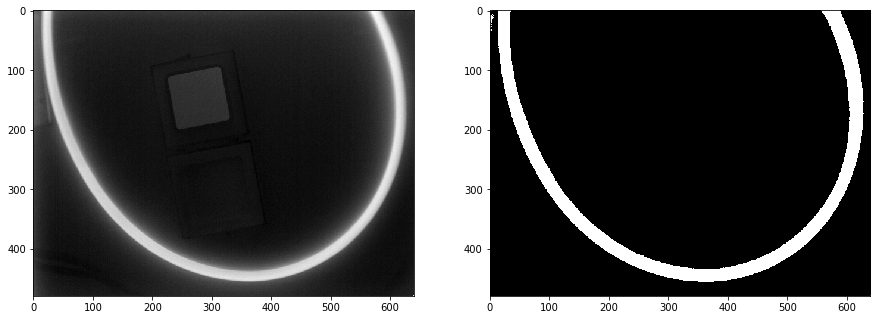

In [133]:
_tmp_img = mangueras[llaves[0]]
utils.side_by_side(_tmp_img, auto_segment(_tmp_img, groups=2))

In [117]:
_tmp_img.flatten().reshape(-1, 1)

array([[109],
       [109],
       [109],
       ...,
       [ 86],
       [ 86],
       [146]], dtype=uint8)

In [123]:
y = [[1, 2], [3, 4]]

In [125]:
print(*y)

[1, 2] [3, 4]


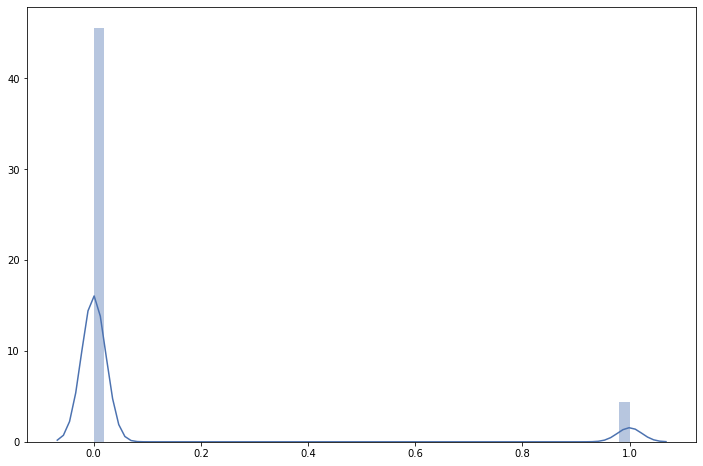

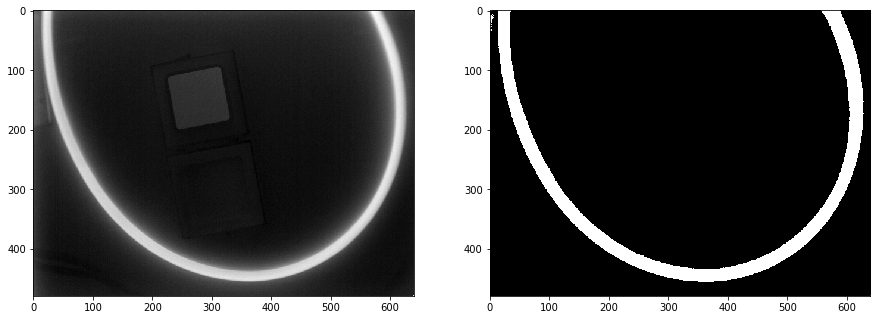

In [284]:
_tmp_img = mangueras[llaves[0]]
mask = auto_segment(_tmp_img, groups=2)
sns.distplot(mask.flatten())
utils.side_by_side(_tmp_img, mask)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 13485328.977020722
start iteration
done sorting
end inner loop
Iteration 1, inertia 13252811.365107602
start iteration
done sorting
end inner loop
Iteration 2, inertia 13252811.365107602
center shift 0.000000e+00 within tolerance 2.233664e-02
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 14893887.94899832
start iteration
done sorting
end inner loop
Iteration 1, inertia 13518975.76939588
start iteration
done sorting
end inner loop
Iteration 2, inertia 13280673.94659304
start iteration
done sorting
end inner loop
Iteration 3, inertia 13245014.90325684
start iteration
done sorting
end inner loop
Iteration 4, inertia 13245014.90325684
center shift 0.000000e+00 within tolerance 2.233664e-02
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 13280673.94659304
start iteration
done sorting
end inner loop
Iteration 1, inertia 1

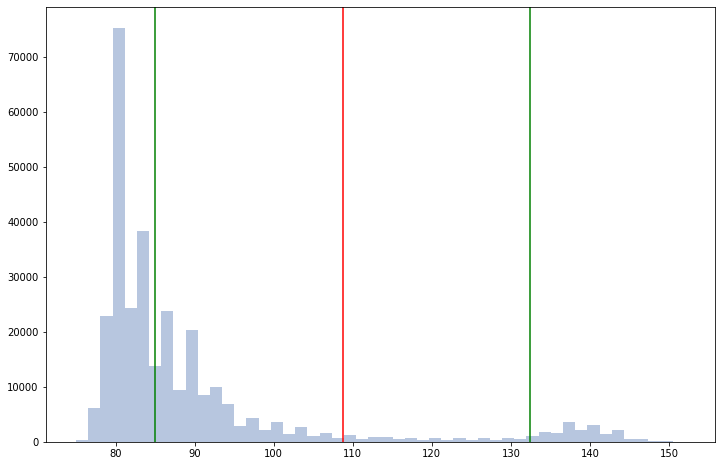

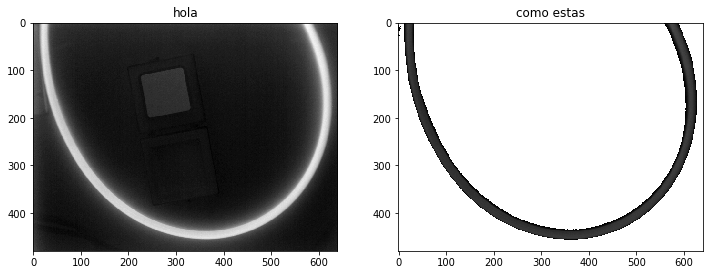

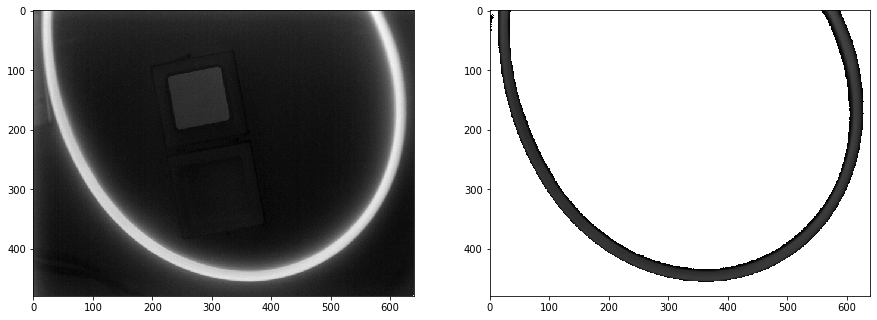

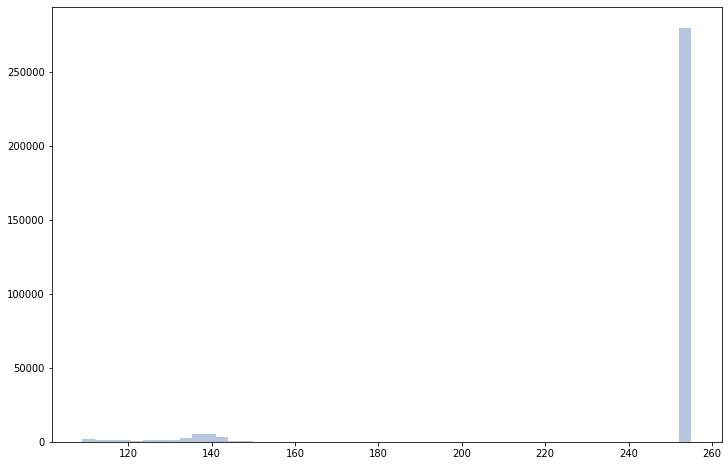

In [198]:
sns.distplot(mask.flatten(), kde=False)

In [170]:
mask[ mask == 63 ].shape

(139985,)

In [177]:
2*512*512


524288

In [181]:
x= np.linspace(0, 1)

In [182]:
x[-]

SyntaxError: invalid syntax (<ipython-input-182-ead70217b2ec>, line 1)

In [184]:
x[::-1] 

array([1.        , 0.97959184, 0.95918367, 0.93877551, 0.91836735,
       0.89795918, 0.87755102, 0.85714286, 0.83673469, 0.81632653,
       0.79591837, 0.7755102 , 0.75510204, 0.73469388, 0.71428571,
       0.69387755, 0.67346939, 0.65306122, 0.63265306, 0.6122449 ,
       0.59183673, 0.57142857, 0.55102041, 0.53061224, 0.51020408,
       0.48979592, 0.46938776, 0.44897959, 0.42857143, 0.40816327,
       0.3877551 , 0.36734694, 0.34693878, 0.32653061, 0.30612245,
       0.28571429, 0.26530612, 0.24489796, 0.2244898 , 0.20408163,
       0.18367347, 0.16326531, 0.14285714, 0.12244898, 0.10204082,
       0.08163265, 0.06122449, 0.04081633, 0.02040816, 0.        ])

In [216]:
pd.core.frame.DataFrame({"h": [np.nan, 1, np.nan, 3]}).fillna(0)

h
0  0.0
1  1.0
2  0.0
3  3.0